In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

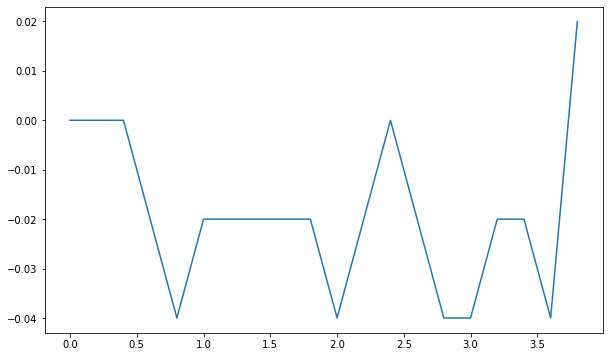

In [89]:
path = 'problem3_output/N=10/'
data = np.loadtxt(path + 'magnetization.dat')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(data[:,0], data[:,1])

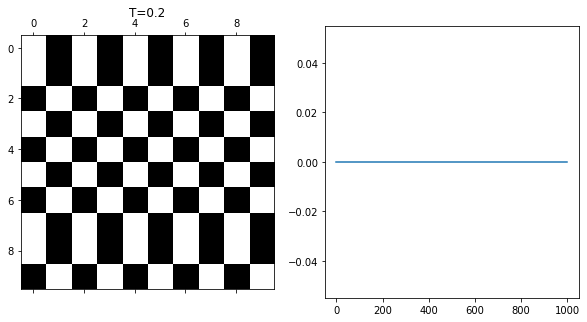

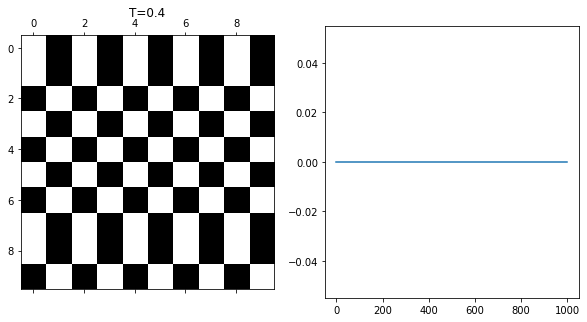

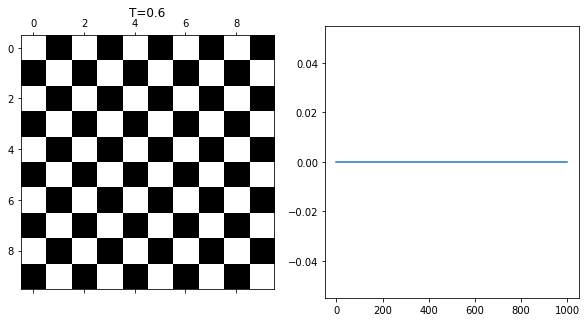

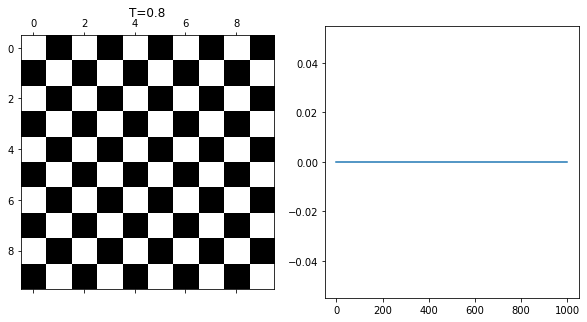

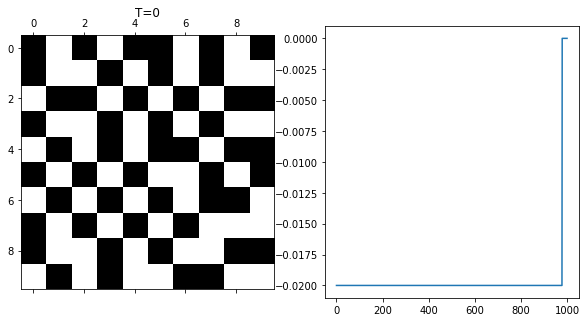

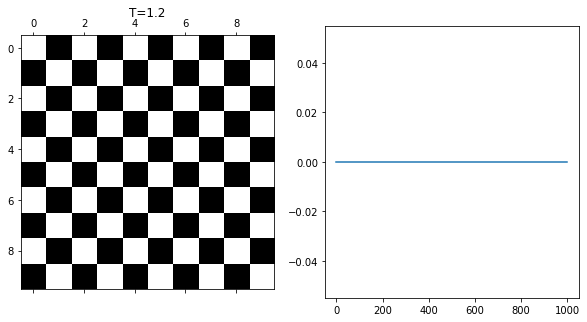

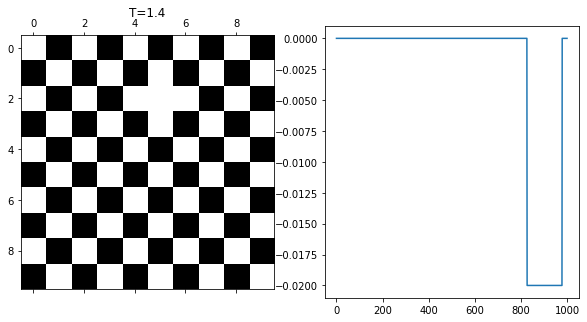

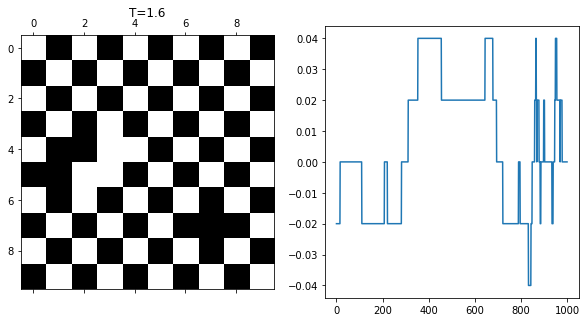

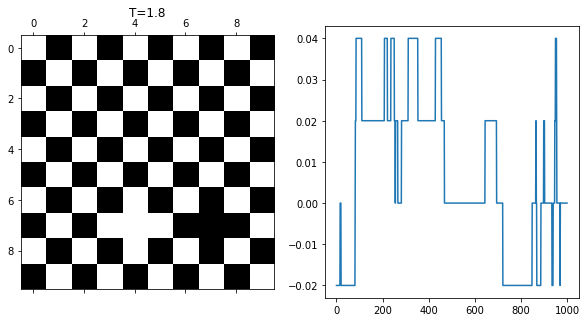

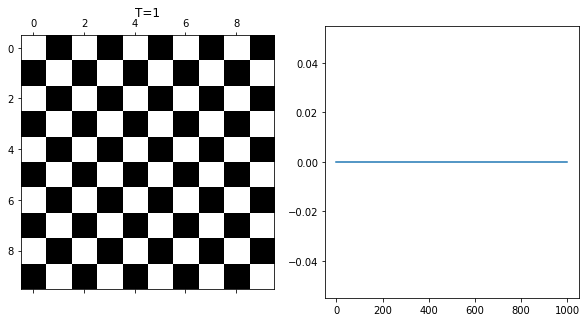

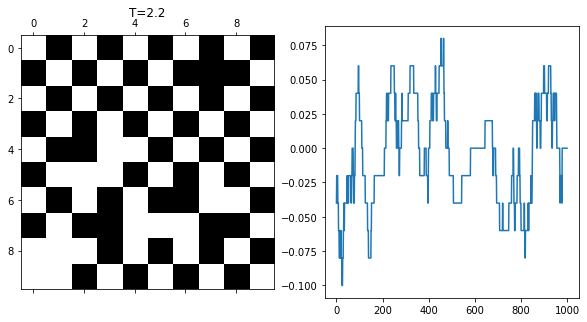

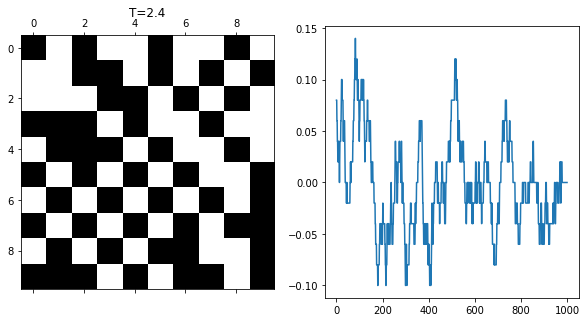

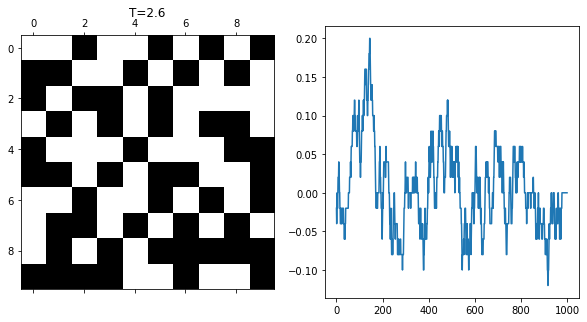

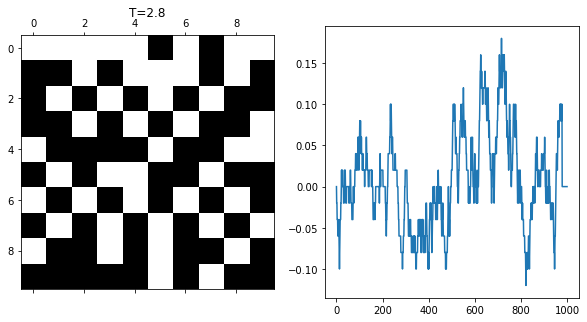

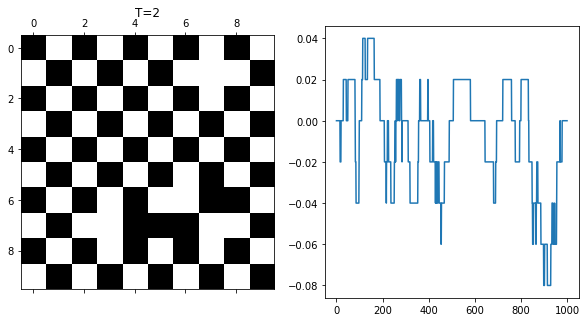

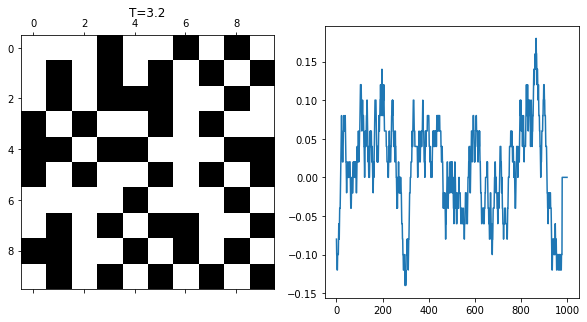

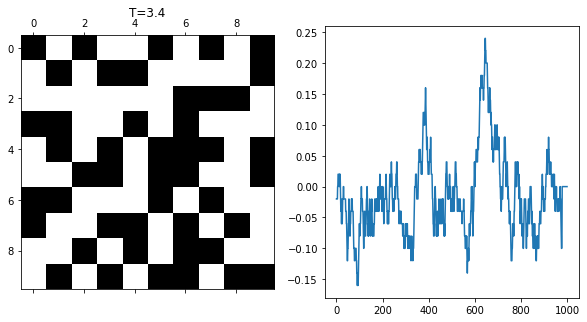

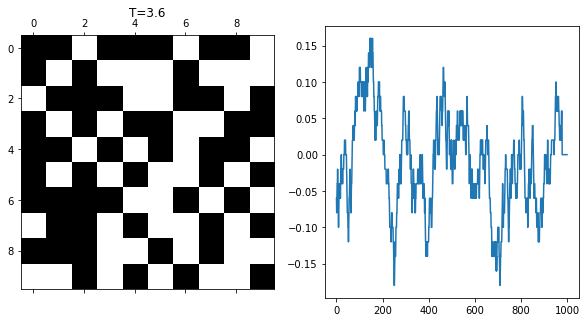

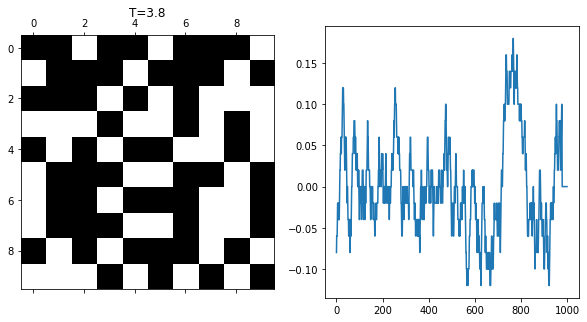

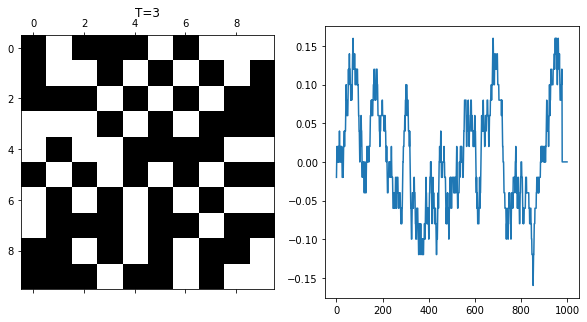

In [90]:
# Plot final lattice
traces = 'problem3_output/N=10/traces/'
path = 'problem3_output/N=10/lattices/'

for filename in os.listdir(path):
    if filename.endswith(".dat"): 
        data_lat = np.loadtxt(path + filename)
        Temperature = filename.split('_')[0]
        trace_name = Temperature + '_magnetization_trace.dat'
        data_trac = np.loadtxt(traces + trace_name)
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].matshow(data_lat, cmap=plt.cm.gray_r)
        ax[1].plot(data_trac)
        ax[0].set_title(Temperature)
